# Description

* Dataset of products from different online fashion retailers
* Below are tasks performed on this data:
    1. Handling null values.
    2. Discard records with invalid IDs.
    3. Feature extraction from columns 'price', 'brand' and 'media'.
    4. Data pre-processing on new features.
    5. Removing product with offer price greater than regular price.
    6. Check on outliers and dropping them.
    7. Removing records with invalid URLs.
    8. Data visualization.
    9. NLP on product description.
    10. Unsupervised clustering.

### Importing required libraries

In [0]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import urllib
from urllib.parse import urlparse

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from IPython.display import Image
from IPython.core.display import HTML

from sklearn import preprocessing
from sklearn.cluster import DBSCAN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing data

In [74]:
data = pd.read_csv(path+'data_engineering_assignment.txt', sep='|', error_bad_lines=False, warn_bad_lines=False)
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_id,name,price,website_id,sku,url,brand,media,description_text
0,5d0b8aca0db7220b86cb4035,Joules Top Dog Underwear Three Pack,"{'offer_price': {'currency': 'GBP', 'value': 3...",5cff5e7fe40f4900046735fa,312838,www.next.co.uk/style/st355408#312838,"{'name': 'joules', 'sub_brand': ''}","{'standard': [{'order': 1, 'url': 'https://xcd...","95% Cotton, 5% Elastane."
1,5d0b8aca0db7220b86cb4036,Figleaves Cheetah Satin Pyjama Set,"{'offer_price': {'currency': 'GBP', 'value': 2...",5cff5e7fe40f4900046735fa,319571,https://www.next.co.uk/style/st324987#319571,"{'name': 'figleaves', 'sub_brand': ''}","{'standard': [{'order': 1, 'url': 'https://xcd...",100% Polyester.
2,5d0b8aca0db7220b86cb4037,"Nike Solid 4"" Swim Short","{'offer_price': {'currency': 'GBP', 'value': 1...",5cff5e7fe40f4900046735fa,335026,https://www.next.co.uk/style/st400645#335026,"{'name': 'nike', 'sub_brand': ''}","{'standard': [{'order': 1, 'url': 'https://xcd...",Nike Swim Boys' Solid Lap 4 Volley Short is a ...
3,5d0b8aca0db7220b86cb4038,Collection Luxe Orchid,"{'offer_price': {'currency': 'GBP', 'value': 1...",5cff5e7fe40f4900046735fa,552266,https://www.next.co.uk/style/st262195#552266,"{'name': 'next', 'sub_brand': ''}","{'standard': [{'order': 1, 'url': 'https://xcd...",Height 85cm
4,5d0b8aca0db7220b86cb4039,River Island White Sleeveless Blazer,"{'offer_price': {'currency': 'GBP', 'value': 5...",5cff5e7fe40f4900046735fa,680971,https://www.next.co.uk/style/st440132#680971,"{'name': 'river island', 'sub_brand': ''}","{'standard': [{'order': 1, 'url': 'https://xcd...",100% Polyester.


### Check for Null Values

In [0]:
data.isna().sum()

_id                    0
name                5163
price               5163
website_id          5163
sku                 5576
url                 5163
brand               5163
media               5163
description_text    5631
dtype: int64

#### Invalid IDs values and all missing values for other features of it

In [0]:
data[data.website_id.isna()].head()

,_id,name,price,website_id,sku,url,brand,media,description_text
16,"Canvas upper with TOMS toe-stitch, and elastic...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,TOMS classic suede insole with cushion for com...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Latex arch insert for added support,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,One-piece outsole for flexibility and durability,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,"With every pair of shoes you purchase, TOMS wi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Dropping rows with invalid IDs

In [0]:
data.drop(data[data.website_id.isna()].index, axis=0, inplace=True)
data = data.reset_index()
data.drop('index', axis=1, inplace=True)
data.isna().sum()

_id                   0
name                  0
price                 0
website_id            0
sku                 413
url                   0
brand                 0
media                 0
description_text    468
dtype: int64

#### Null values for SKU codes and Product description
* Still we see few null values for SKU Codes and Product description.
* We can replace them with value 'No SKU Code' and 'No description' and retain other feature for products for analysis

In [0]:
data.loc[data.sku.isna(), 'sku'] = 'No SKU Code'
data.loc[data.description_text.isna(), 'description_text'] = 'No description'
data.isna().sum()

_id                 0
name                0
price               0
website_id          0
sku                 0
url                 0
brand               0
media               0
description_text    0
dtype: int64

* A glance at shape of data we have

In [0]:
print('Rows :', data.shape[0], 'Columns :', data.shape[1])

Rows : 318278 Columns : 9


### Feature extraction from column 'price', 'brand', and 'media'
* Data in this column are in JSON Objects
* So, we can extract those key-values pairs and add them to features.

#### Extracting from column 'price'

In [0]:
data['price'] = data['price'].apply(lambda x : eval(x))
price_data = json_normalize(data['price'])
data.drop('price', axis=1, inplace=True)
price_data.head()

,offer_price.currency,offer_price.value,regular_price.currency,regular_price.value,basket_price.value,basket_price.currency
0,GBP,35.0,GBP,35.0,NaN,NaN
1,GBP,25.0,GBP,25.0,NaN,NaN
2,GBP,15.0,GBP,15.0,NaN,NaN
3,GBP,150.0,GBP,150.0,NaN,NaN
4,GBP,55.0,GBP,55.0,NaN,NaN


In [0]:
price_data['offer_price.currency'].unique()

array(['GBP'], dtype=object)

* Either Currency is GBP or NaN so dropping currency columns from price_data

In [0]:
drop = ['offer_price.currency', 'regular_price.currency', 'basket_price.currency']
for col in drop:
  price_data.drop(col, axis=1, inplace=True)
price_data.head()

,offer_price.value,regular_price.value,basket_price.value
0,35.0,35.0,NaN
1,25.0,25.0,NaN
2,15.0,15.0,NaN
3,150.0,150.0,NaN
4,55.0,55.0,NaN


#### Extracting from column 'brand'


In [0]:
data['brand'] = data['brand'].apply(lambda x : eval(x))
brand_data = json_normalize(data['brand'])
data.drop('brand', axis=1, inplace=True)
brand_data.head()

,name,sub_brand
0,joules,
1,figleaves,
2,nike,
3,next,
4,river island,


* We got some missing values in form of empty strings
* Replacing them with 'No brand name' for name and 'No sub-brand name' for sub_brand

In [0]:
brand_data.loc[brand_data.name.values == '', 'name'] = 'No brand name'
brand_data.loc[brand_data.sub_brand.values == '', 'sub_brand'] = 'No sub-brand name'
brand_data.head()

,name,sub_brand
0,joules,No sub-brand name
1,figleaves,No sub-brand name
2,nike,No sub-brand name
3,next,No sub-brand name
4,river island,No sub-brand name


* We already got a column with 'name' for product name
* So renaming brand columns with 'brand_name', 'sub_brand_name'

In [0]:
brand_data.columns = ['brand_name', 'sub_brand_name']

#### Extracting from column 'media'
* This contains three keys standard, thumbnail and large.
* Extracting URL values for those and creating columns in data for it

In [0]:
data['media'] = data['media'].apply(lambda x : eval(x))
standard_url = []
thumbnail_url = []
large_url = []
for val in data['media']:
  try:
      standard_url.append(val['standard'][0]['url'])
  except IndexError:
      standard_url.append('No media URL')

  try:
      thumbnail_url.append(val['thumbnail'][0]['url'])
  except (IndexError, KeyError):
      thumbnail_url.append('No media URL')

  try:
      large_url.append(val['large'][0]['url'])
  except (IndexError, KeyError):
      large_url.append('No media URL')

data['standard_media_url'] = standard_url
data['thumbnail_media_url'] = thumbnail_url
data['large_media_url'] = large_url

data.drop('media', axis=1, inplace=True)

* Again a check on shape before concatenating them with original data 

In [0]:
data.shape, price_data.shape, brand_data.shape

((318278, 9), (318278, 3), (318278, 2))

#### Concatenating all feature obtained with original data
* Also a quick glance on our data with new feature

In [0]:
data = pd.concat([data, price_data, brand_data], axis=1)
data.head()

,_id,name,website_id,sku,url,description_text,standard_media_url,thumbnail_media_url,large_media_url,offer_price.value,regular_price.value,basket_price.value,brand_name,sub_brand_name
0,5d0b8aca0db7220b86cb4035,Joules Top Dog Underwear Three Pack,5cff5e7fe40f4900046735fa,312838,www.next.co.uk/style/st355408#312838,"95% Cotton, 5% Elastane.",https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,35.0,35.0,NaN,joules,No sub-brand name
1,5d0b8aca0db7220b86cb4036,Figleaves Cheetah Satin Pyjama Set,5cff5e7fe40f4900046735fa,319571,https://www.next.co.uk/style/st324987#319571,100% Polyester.,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,25.0,25.0,NaN,figleaves,No sub-brand name
2,5d0b8aca0db7220b86cb4037,"Nike Solid 4"" Swim Short",5cff5e7fe40f4900046735fa,335026,https://www.next.co.uk/style/st400645#335026,Nike Swim Boys' Solid Lap 4 Volley Short is a ...,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,15.0,15.0,NaN,nike,No sub-brand name
3,5d0b8aca0db7220b86cb4038,Collection Luxe Orchid,5cff5e7fe40f4900046735fa,552266,https://www.next.co.uk/style/st262195#552266,Height 85cm,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,150.0,150.0,NaN,next,No sub-brand name
4,5d0b8aca0db7220b86cb4039,River Island White Sleeveless Blazer,5cff5e7fe40f4900046735fa,680971,https://www.next.co.uk/style/st440132#680971,100% Polyester.,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,55.0,55.0,NaN,river island,No sub-brand name


### Data description
* '_id' : Product IDs
* 'name' : Product Names
* 'website_id' : IDs for company websites
* 'sku' : SKU codes for particular products
* 'url' : URLs for product listed on websites
* 'description_text' : Product descriptions
* 'media': URLs for Standard , Large and Thumbnails media
* 'price': Product price in GBP (Offer and Regular prices)
* 'brand': Brand name of product

### Data pre-processing on newly obtained data

#### Again null values check with new columns, checking with percentage

In [0]:
data.isna().sum()/data.shape[0] * 100

_id                     0.000000
name                    0.000000
website_id              0.000000
sku                     0.000000
url                     0.000000
description_text        0.000000
standard_media_url      0.000000
thumbnail_media_url     0.000000
large_media_url         0.000000
offer_price.value       0.104311
regular_price.value     0.104311
basket_price.value     65.510340
brand_name              0.000000
sub_brand_name          0.000000
dtype: float64

* 65.51% of 'basket_price.value' are null values, hence we can drop it.

In [0]:
data.drop('basket_price.value', axis=1, inplace=True)

* Also 'offer_price.value' and 'regular_price.value' are just 0.10% null. So, we can drop that paticular rows.

In [0]:
data.drop(data[data['regular_price.value'].isna()].index, axis=0, inplace=True)
data = data.reset_index()
data.drop('index', axis=1, inplace=True)
data.isna().sum()

_id                    0
name                   0
website_id             0
sku                    0
url                    0
description_text       0
standard_media_url     0
thumbnail_media_url    0
large_media_url        0
offer_price.value      0
regular_price.value    0
brand_name             0
sub_brand_name         0
dtype: int64

#### Quick check on stats

In [0]:
data.describe(include='all')

,_id,name,website_id,sku,url,description_text,standard_media_url,thumbnail_media_url,large_media_url,offer_price.value,regular_price.value,brand_name,sub_brand_name
count,317946,317946,317946,317946,317946,317946,317946,317946,317946,3.179460e+05,3.179460e+05,317946,317946
unique,317946,257399,4,299797,317946,275543,311110,238074,108855,NaN,NaN,4776,1
top,5d49a619a3ecbbd90d63ff98,logo print T-shirt,5d0cc7b68a66a100014acdb0,No SKU Code,https://www.farfetch.com/uk/shopping/men/eleve...,100% Cotton.,No media URL,No media URL,No media URL,NaN,NaN,next,No sub-brand name
freq,1,450,109773,412,1,2213,58,78689,208173,NaN,NaN,25154,317946
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.239519e+02,2.643545e+02,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.580080e+03,3.272166e+03,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000e+01,2.000000e+01,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000e+01,4.500000e+01,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.930000e+02,2.400000e+02,NaN,NaN


* 'sub_brand_name' has 1 unique value, so dropping that column

In [0]:
data.drop('sub_brand_name', axis=1, inplace=True)

* 'website_id' has 4 uniques IDs, so we can extract website name from associated URLs for it and create a column for analysis.

In [0]:
data['website_name'] = data['url'].apply(lambda link : urlparse(link).netloc)

#### Checking for rows with offer price greater than regular price

In [0]:
print('Total records with offer price greater than regular price: ',data.loc[data['offer_price.value'] > data['regular_price.value']].shape[0])

Total records with offer price greater than regular price:  14


In [0]:
data.loc[data['offer_price.value'] > data['regular_price.value']].head()

,_id,name,website_id,sku,url,description_text,standard_media_url,thumbnail_media_url,large_media_url,offer_price.value,regular_price.value,brand_name,website_name
78687,5d09dc3365a89b368ffe6920,Black Lace Bardot Bodysuit,5cff5e30e40f4900046735f8,cmd4463,www.prettylittlething.com/black-lace-bardot-bo...,This bodysuit is perfect for any weekend occas...,https://cdn-img.prettylittlething.com/e/3/c/b/...,https://cdn-img.prettylittlething.com/e/3/c/b/...,No media URL,18.0,15.0,GLOBALLE,
88687,5d09e34a65a89b368ffe9031,Black Lace Gold Button Blazer Dress,5cff5e30e40f4900046735f8,clw9088,www.prettylittlething.com/black-lace-gold-butt...,Switch your simple LBD for the lace blazer dre...,https://cdn-img.prettylittlething.com/c/a/7/9/...,https://cdn-img.prettylittlething.com/c/a/7/9/...,No media URL,40.0,16.0,UNIQUE21,
98685,5d09e86665a89b368ffeb741,Petite Brown Snake Print Floaty Shorts,5cff5e30e40f4900046735f8,clv7163,www.prettylittlething.com/petite-brown-snake-p...,"We are loving print this season girl, and this...",https://cdn-img.prettylittlething.com/0/4/3/9/...,https://cdn-img.prettylittlething.com/0/4/3/9/...,No media URL,18.0,6.0,4FASHION,
108682,5d35a2cdd41118b4e396d9ff,Red Strappy Thick Lace Frill Hem Midi Dress,5cff5e30e40f4900046735f8,clz7400,www.prettylittlething.com/red-strappy-thick-la...,Get that jaw-dropping look with this killer mi...,https://cdn-img.prettylittlething.com/7/8/7/7/...,https://cdn-img.prettylittlething.com/7/8/7/7/...,No media URL,45.0,15.0,4fashion,
168048,5d49ce8aa3ecbbd90d649907,Dinky crossbody bag,5d0cc7b68a66a100014acdb0,11538699,www.farfetch.com/uk/shopping/women/coach-dinky...,Black leather Dinky crossbody bag from Coach.,https://cdn-images.farfetch-contents.com/11/53...,https://cdn-images.farfetch-contents.com/11/53...,https://cdn-images.farfetch-contents.com/11/53...,458.0,413.0,coach,


* Removing records with offer price value greater than regular price value

In [0]:
data.drop(data.loc[data['offer_price.value'] > data['regular_price.value']].index, axis=0, inplace=True)
data = data.reset_index()
data.drop('index', axis=1, inplace=True)
print('Total records with offer price greater than regular price: ',data.loc[data['offer_price.value'] > data['regular_price.value']].shape[0])
data.shape

Total records with offer price greater than regular price:  0


(317932, 13)

#### Functions for BoxPlot

In [0]:
def boxPlot_single(numColumn):
  plt.rcParams['figure.figsize'] = (10.0, 5.0)
  plt.title('Box plot for '+numColumn)
  sns.set(style="whitegrid")
  ax = sns.boxplot(data[numColumn])

def boxPlot_multi(numColumn, catColumn):
  plt.rcParams['figure.figsize'] = (20.0, 10.0)
  plt.title('Box plot for ' +numColumn+ ' per '+catColumn)
  sns.set(style="whitegrid")
  ax = sns.boxplot(x=catColumn, y=numColumn, data=data)

  for i,artist in enumerate(ax.artists):
      col = artist.get_facecolor()
      artist.set_edgecolor(col)
      artist.set_facecolor('None')

      for j in range(i*6,i*6+6):
          line = ax.lines[j]
          line.set_color(col)
          line.set_mfc(col)
          line.set_mec(col)

#### Checking and for outliers in price

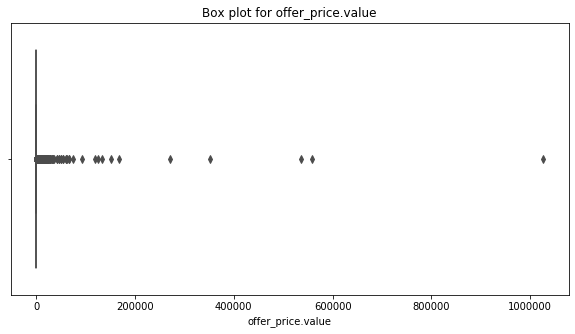

In [0]:
boxPlot_single('offer_price.value')

In [0]:
def removeOutliers(price, data):
  print('Total records with offer price greater than ',price,': ',data.loc[data['offer_price.value'] > price].shape[0])
  print('Removing records...')
  data.drop(data.loc[data['offer_price.value'] > price].index, axis=0, inplace=True)
  data = data.reset_index()
  data.drop('index', axis=1, inplace=True)
  print('Total records with offer price greater than ',price,': ',data.loc[data['offer_price.value'] > price].shape[0])

In [0]:
removeOutliers(5000, data)

Total records with offer price greater than  5000 :  706
Removing records...
Total records with offer price greater than  5000 :  0


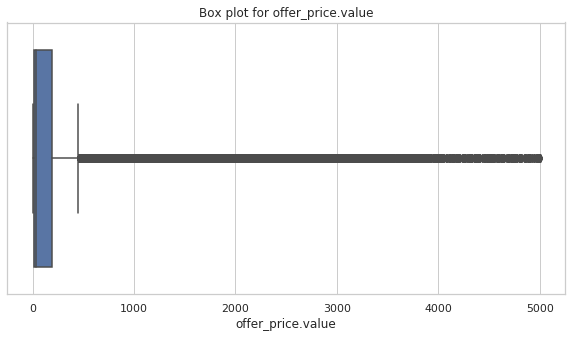

In [0]:
boxPlot_single('offer_price.value')

In [0]:
removeOutliers(200, data)

Total records with offer price greater than  200 :  76756
Removing records...
Total records with offer price greater than  200 :  0


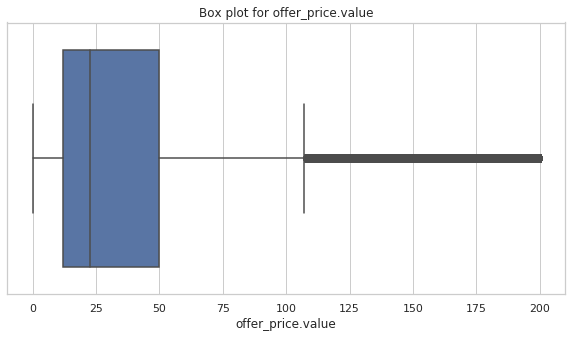

In [0]:
boxPlot_single('offer_price.value')

In [0]:
print('Records left after removing outliers (offer price greater than 200 GBP): ', data.shape[0])
print('Records dropped in precentage :', round((1 - data.shape[0]/317932) * 100, 2))

Records left after removing outliers (offer price greater than 200 GBP):  240470
Records dropped in precentage : 24.36


* After removing most of the outliers, Still distribution is left skewed.
* Data is dropped by 24.36%

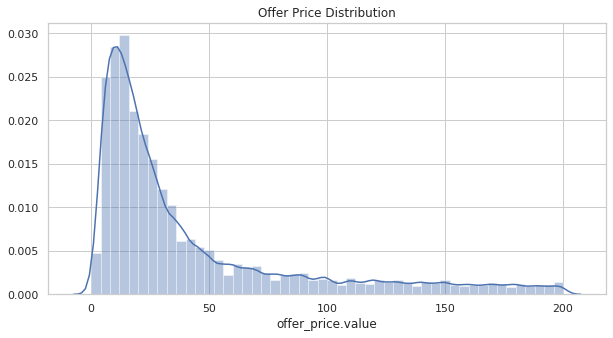

In [0]:
plt.title('Offer Price Distribution')
sns.distplot(data['offer_price.value'])

#### BoxPlot for offer price by each website

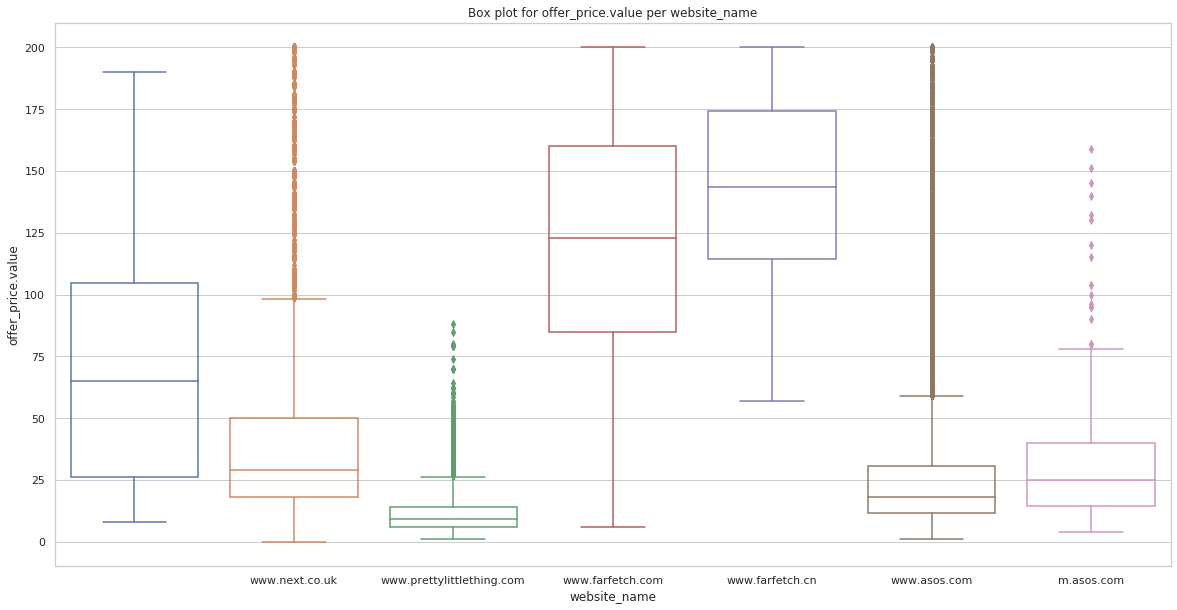

In [0]:
boxPlot_multi('offer_price.value', 'website_name')

#### Dropping records with invalid URLs

In [0]:
def validate_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc])
  except ValueError:
    return False

In [0]:
data['valid_url'] = data['url'].apply(lambda link : validate_url(link))

In [0]:
print('Total records with invalid URLs : ',data[data['valid_url'] == False].shape[0])
data[data['valid_url'] == False].index

Total records with invalid URLs :  16


Int64Index([     0,   9809,  19609,  29455,  39327,  49116,  58949,  68781,
            138077, 148065, 158049, 178027, 217981, 257936, 267936, 307932],
           dtype='int64')

In [0]:
data.drop(data[data['valid_url'] == False].index, axis=0, inplace=True)
data = data.reset_index()
data.drop('index', axis=1, inplace=True)
print('Total records with invalid URLs : ',data[data['valid_url'] == False].shape[0])
data.drop('valid_url', axis=1, inplace=True)

Total records with invalid URLs :  0


### Data Visualization

#### Bar graphs for top categories

In [0]:
def barGraph_count(catColumn, top=5):
  temp = data[catColumn].value_counts()
  temp = temp.reset_index()
  temp.columns = [catColumn, 'count']
  temp = temp.head(top)
  temp = pd.DataFrame(temp)
  ax = sns.barplot(x=catColumn, y='count', data=temp)
  del temp

* Top 10 product name
* 'logo print T-shirt' and 'logo T-shirt' topping chart with around 375 and 195 products respectively

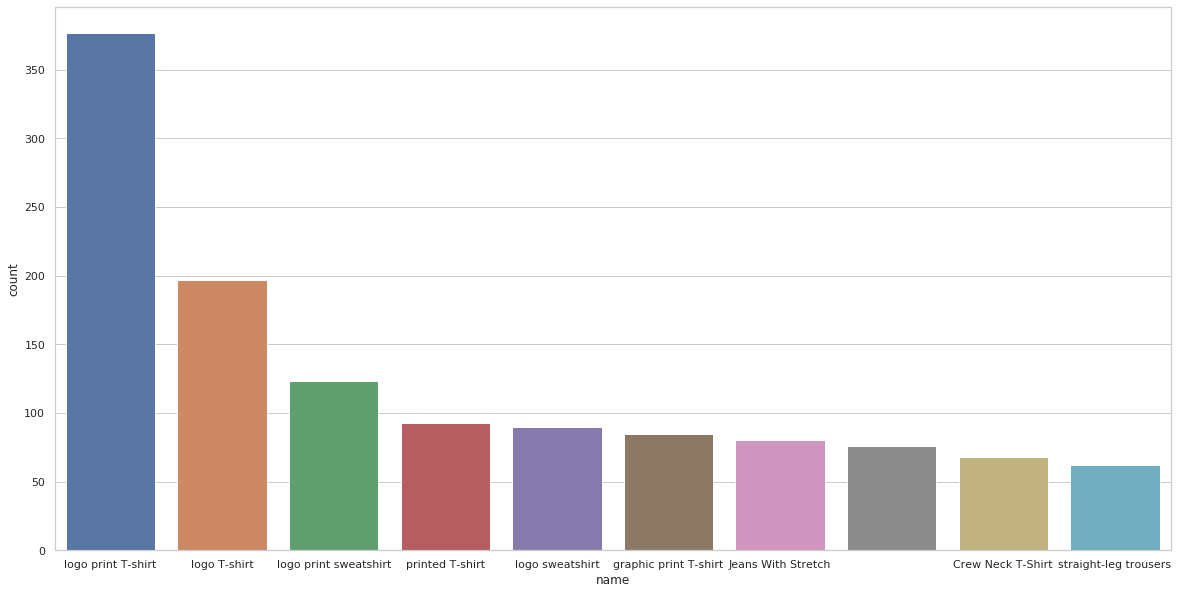

In [0]:
barGraph_count('name', top=10)

* Top 10 brand names
* 'next' on top with around 22500 products

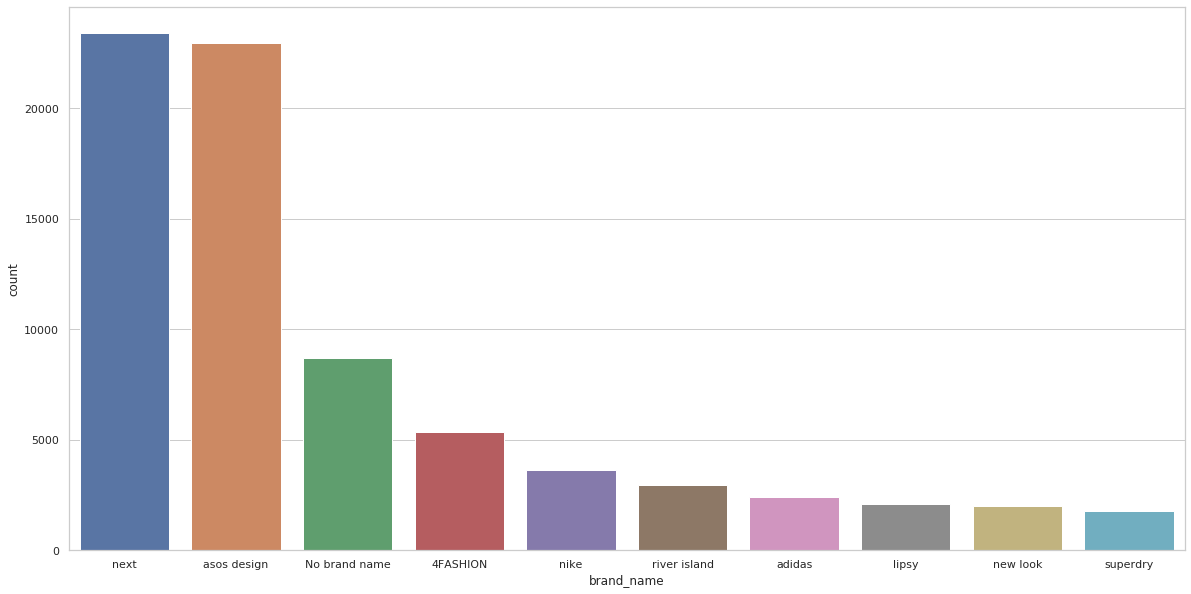

In [0]:
barGraph_count('brand_name', top=10)

* Top 5 websites
* www.asos.com with around 95000 products

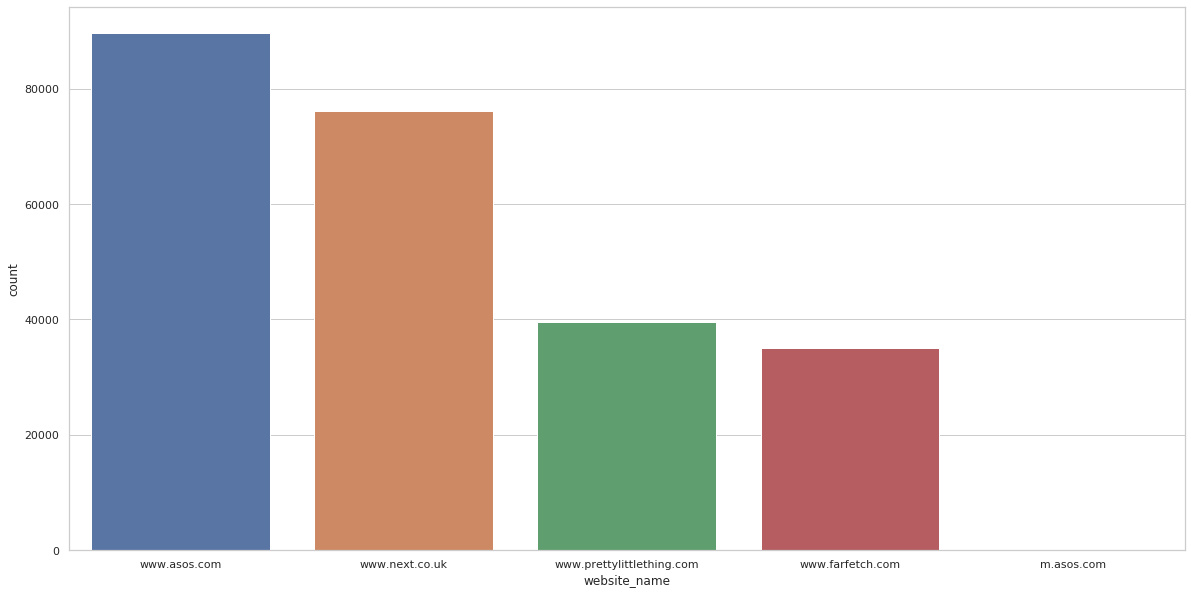

In [0]:
barGraph_count('website_name')

#### Bar graphs for top discounts

In [0]:
def barGraph_discount(catColumn, top = 10, percent=50):
  temp = data.groupby(catColumn)['offer_price.value', 'regular_price.value'].mean()
  temp = temp.reset_index()
  temp['discount_percent'] = round((1 - temp['offer_price.value']/temp['regular_price.value']) * 100, 2)
  temp.sort_values(by=['discount_percent'], inplace=True, ascending=False)
  temp = temp.loc[:,[catColumn, 'discount_percent']].head(top)
  ax = sns.barplot(x=catColumn, y='discount_percent', data=temp,  palette="Blues_d")
  del temp

* Top discounts by brand name
* Top 10: projectt, seeker, kowtow, parka london and other are with discounts around 77-84% 

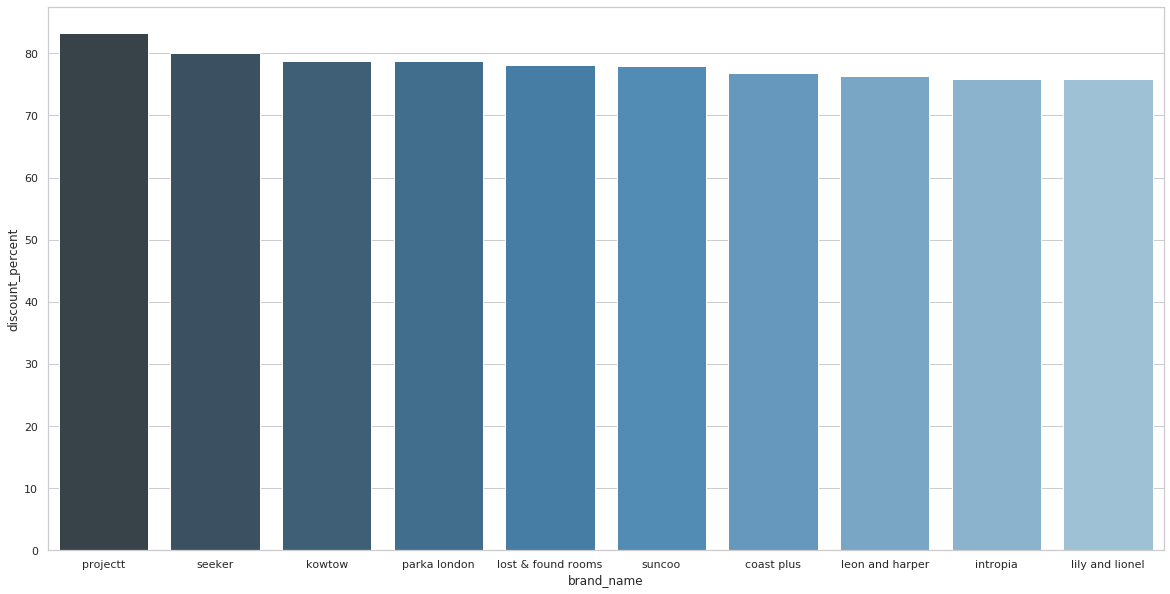

In [0]:
barGraph_discount('brand_name', top=10, percent=50)

* Top discounts by website name
* www.next.co.uk with no discounts at all
* www.prettylittlethings with high discounts for around 40%

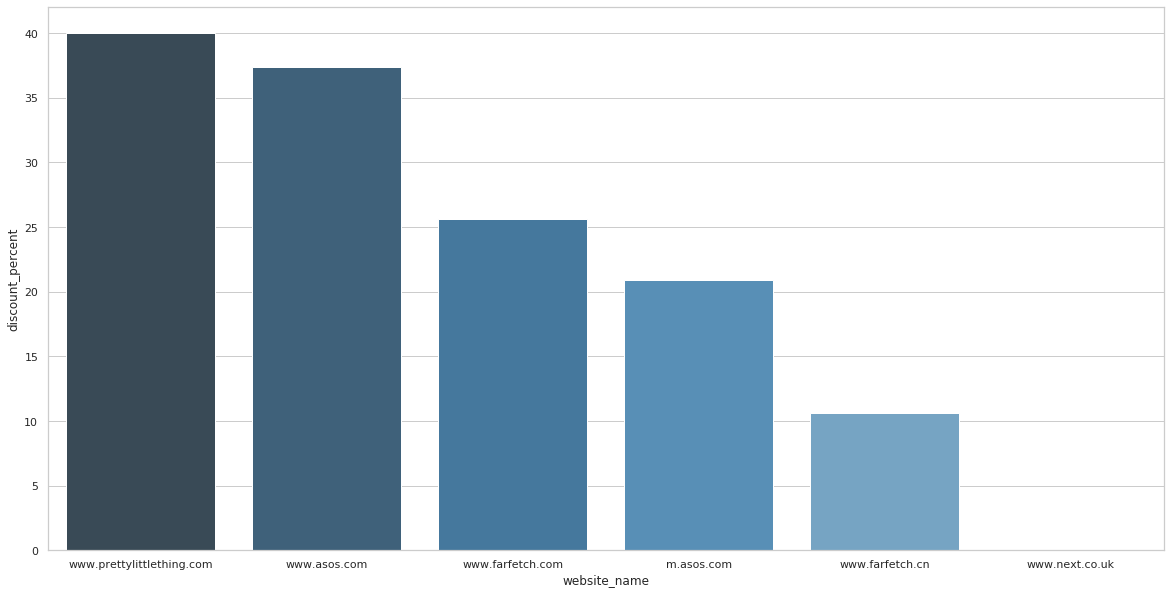

In [0]:
barGraph_discount('website_name', top=6, percent=0)

### Text pre-processing on 'description_text'

* Function to remove punctuation, stopwords and lemmatization

In [0]:
def remove_punctuation(text):
  return [word for word in text if word.isalpha()]

def remove_punctuation_from_word(text):
  token = []
  for word in text:
    if word[-1].isalpha():
      token.append(word)
    else:
      token.append(word[:-1]) 
  return token

stop_words = stopwords.words('english')
def remove_stopword(text):
  return [w for w in text if not w in stop_words]
    
def lemmatizing(text):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(word) for word in text]


* Here we perform processing on 'description_text'
* Convert to lowercase -> tokenization -> removing punctuation -> removing stop words -> Lemmatization

In [0]:
data['processed_text'] = data['description_text']

print('Converting to lower case...')
data['processed_text'] = [text.strip().lower() for text in data['processed_text']]
print('Done')

print('Tokenizing...')
data['processed_text'] = [word_tokenize(text) for text in data['processed_text']]
print('Done')

print('Removing punctuation...')
data['processed_text'] = [remove_punctuation(text) for text in data['processed_text']]
data['processed_text'] = [remove_punctuation_from_word(text) for text in data['processed_text']]
print('Done')

print('Removing Stop words...')
data['processed_text'] = [remove_stopword(text) for text in data['processed_text']]
print('Done')

print('Lemmatizing...')
data['processed_text'] = [lemmatizing(text) for text in data['processed_text']]
print('Text processing Done')

Converting to lower case...
Done
Tokenizing...
Done
Removing punctuation...
Done
Removing Stop words...
Done
Lemmatizing...
Text processing Done


* Quick look at processed text

In [0]:
data.loc[:,['description_text','processed_text']].head(10)

,description_text,processed_text
0,100% Polyester.,[polyester]
1,Nike Swim Boys' Solid Lap 4 Volley Short is a ...,"[nike, swim, boy, solid, lap, volley, short, d..."
2,Height 85cm,[height]
3,100% Polyester.,[polyester]
4,In a leopard print this tie up heel.,"[leopard, print, tie, heel]"
5,"70% Viscose, 26% Nylon, 4% Elastane.","[viscose, nylon, elastane]"
6,Wish your loved one a Hoppy Birthday with this...,"[wish, loved, one, hoppy, birthday, beer, hawk..."
7,With adjustable strap fastening.,"[adjustable, strap, fastening]"
8,18 carat gold-plated sterling silver. Comes in...,"[carat, sterling, silver, come, gift, box]"
9,With blackout lining.,"[blackout, lining]"


#### Word Cloud with processed text and Standard media URL

In [0]:
def img_with_wordcloud(row):
  word_cloud = WordCloud(max_words=5, background_color='white').generate(' '.join(data['processed_text'][row]))
  plt.figure(figsize=(5,5),facecolor = 'white', edgecolor='blue')
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()
  display(Image(url= data['standard_media_url'][row]))

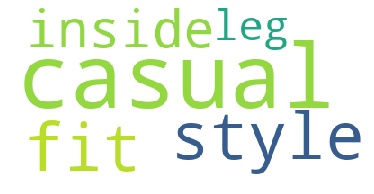

In [0]:
img_with_wordcloud(4123)

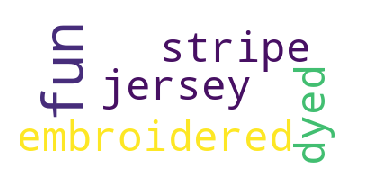

In [0]:
img_with_wordcloud(2575)

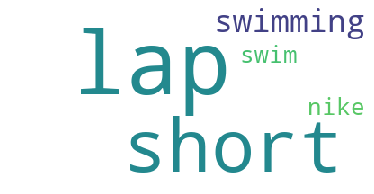

In [0]:
img_with_wordcloud(1)

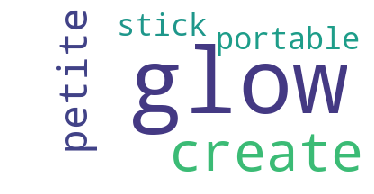

In [0]:
img_with_wordcloud(2745)

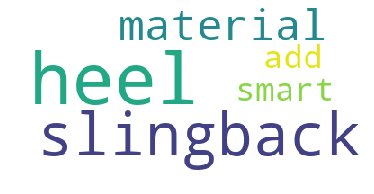

In [0]:
img_with_wordcloud(564)

#### Creating Tags for products with processed text

* As we see processed text are almost can be used as tags for image
* So, creating tag columns with top 3 words from processed text

In [0]:
def get_tag(text):
  tag = {}
  try:
    tagDict = WordCloud(max_words=3).generate(' '.join(text)).words_
    tag['tag_1'] = list(tagDict.keys())[0]
    try:
      tag['tag_2'] = list(tagDict.keys())[1]
    except IndexError:
      tag['tag_2'] = ''
    try:
      tag['tag_3'] = list(tagDict.keys())[2]
    except IndexError:
      tag['tag_3'] = ''
    return tag
  except ValueError:
    return {}

In [0]:
# tags = [get_tag(x) for x in data['processed_text']]
# tags = pd.DataFrame(tags)
# tags.to_csv(path+'tags.csv',index=False)
tags = pd.read_csv(path+'tags.csv', header=0)
tags.head()

,tag_1,tag_2,tag_3
0,polyester,NaN,NaN
1,lap,short,swimming
2,height,NaN,NaN
3,polyester,NaN,NaN
4,leopard,print,tie


#### Bar graph for tags

In [0]:
def barGraph_tags(top = 5):
  temp = pd.concat([tags['tag_1'],tags['tag_2'],tags['tag_3']]).value_counts()
  temp = pd.DataFrame(temp)
  temp = temp.reset_index()
  temp = temp.head(10)
  ax = sns.barplot(x='index', y=0, data=temp)

* 'Cotton' is most used word to describe, followed by 'look', 'design' and 'black'

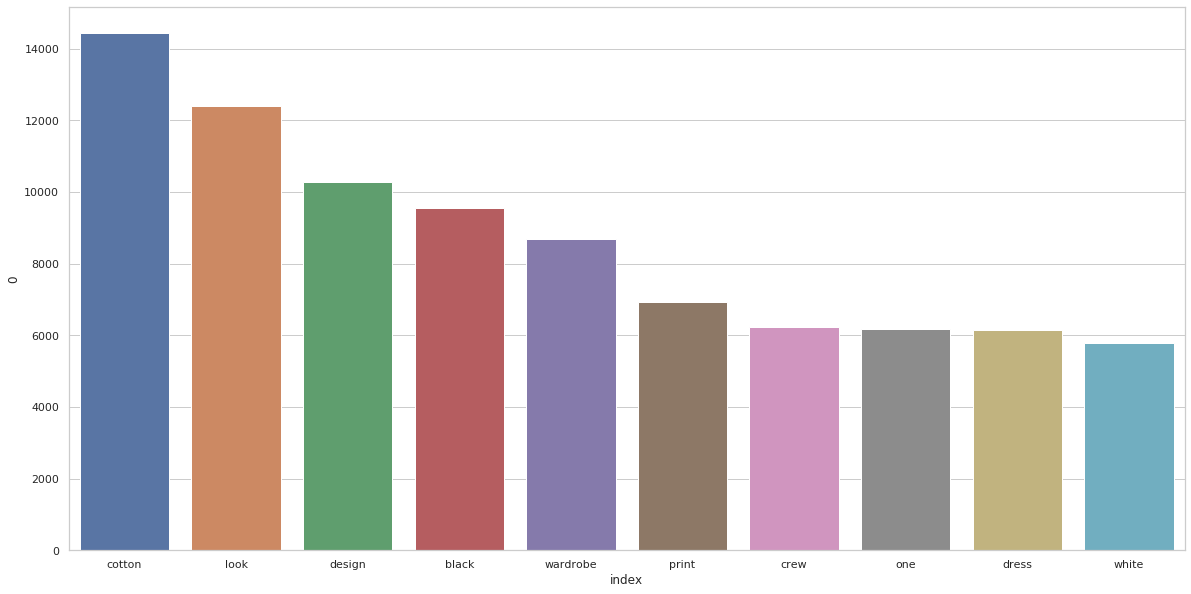

In [0]:
barGraph_tags(top=10)

* Adding column tag_1, tag_2 and tag_3 to data
* Dropping column 'processed_text'

In [0]:
data.drop('processed_text', axis = 1, inplace = True)
tags = tags.replace(np.nan, '')
data = pd.concat([data, tags], axis=1)

In [0]:
data.head()

,_id,name,website_id,sku,url,description_text,standard_media_url,thumbnail_media_url,large_media_url,offer_price.value,regular_price.value,brand_name,website_name,tag_1,tag_2,tag_3
0,5d0b8aca0db7220b86cb4036,Figleaves Cheetah Satin Pyjama Set,5cff5e7fe40f4900046735fa,319571,https://www.next.co.uk/style/st324987#319571,100% Polyester.,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,25.0,25.0,figleaves,www.next.co.uk,polyester,,
1,5d0b8aca0db7220b86cb4037,"Nike Solid 4"" Swim Short",5cff5e7fe40f4900046735fa,335026,https://www.next.co.uk/style/st400645#335026,Nike Swim Boys' Solid Lap 4 Volley Short is a ...,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,15.0,15.0,nike,www.next.co.uk,lap,short,swimming
2,5d0b8aca0db7220b86cb4038,Collection Luxe Orchid,5cff5e7fe40f4900046735fa,552266,https://www.next.co.uk/style/st262195#552266,Height 85cm,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,150.0,150.0,next,www.next.co.uk,height,,
3,5d0b8aca0db7220b86cb4039,River Island White Sleeveless Blazer,5cff5e7fe40f4900046735fa,680971,https://www.next.co.uk/style/st440132#680971,100% Polyester.,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,55.0,55.0,river island,www.next.co.uk,polyester,,
4,5d0b8aca0db7220b86cb403a,Faith Animal Print Heel,5cff5e7fe40f4900046735fa,L07550,https://www.next.co.uk/style/esl07550#l07550,In a leopard print this tie up heel.,https://xcdn.next.co.uk/Common/Items/Default/D...,No media URL,No media URL,52.0,52.0,faith,www.next.co.uk,leopard,print,tie


#### Let's check if we can cluster data based on brand_name, website_name, and tags columns for products

* Taking subset of data with those columns in cluster_data

In [0]:
cluster_data = data.loc[:,['brand_name', 'website_name', 'tag_1', 'tag_2', 'tag_3']]
cluster_data.head()

,brand_name,website_name,tag_1,tag_2,tag_3
0,figleaves,www.next.co.uk,polyester,,
1,nike,www.next.co.uk,lap,short,swimming
2,next,www.next.co.uk,height,,
3,river island,www.next.co.uk,polyester,,
4,faith,www.next.co.uk,leopard,print,tie


* Preprocessing

In [0]:
le = preprocessing.LabelEncoder()
for c in cluster_data.columns:
  cluster_data[c] = le.fit_transform(cluster_data[c])
cluster_data.head()

,brand_name,website_name,tag_1,tag_2,tag_3
0,1399,4,4028,0,0
1,2561,4,2903,5761,7308
2,2550,4,2407,0,0
3,3011,4,4028,0,0
4,1350,4,2973,4992,7529


* Applying DBSCAN, as we don't know how many categories of product do we have

In [0]:
db = DBSCAN(eps=1, min_samples=100).fit(cluster_data) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 
  
# Number of clusters in labels, ignoring noise if present. 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
print('Number of clusters: ',n_clusters_)

Number of clusters:  61


* Creating column cluster number for each product

In [0]:
data['clusters'] = labels

#### And a check on random cluster number and standard media URL

In [0]:
def checkClusters(clusterNumber):
  temp = data[data['clusters'] == clusterNumber].head()
  for url in temp['standard_media_url'].values:
    display(Image(url= url))

* Cluster with adult footwears

In [0]:
checkClusters(24)

* Cluster with women wears with some specific type of dress

In [0]:
checkClusters(25)

* Cluster with bedsheet and pillow cover 

In [0]:
checkClusters(26)

* Cluster with kids top wears

In [0]:
checkClusters(8)

Cluster with kids footwears

In [0]:
checkClusters(16)

* Cluster with home decors or specific to flowers

In [0]:
checkClusters(0)

#### We can say that cluster with help of 'brand_name', 'website_name' and 'tags' generated by description of product performed well.